In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(os.path.dirname(file_path)))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)
    
import time
import jax
from jax import lax
from jax import flatten_util
from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *
from jax import vmap
import jax.numpy as jnp
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio

import jax
import jax.numpy as jnp
import jaxopt
from jaxopt import LBFGS
import random


Project root: /oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs


In [2]:
from jax import config
config.update("jax_default_matmul_precision", "float32")

In [3]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [4]:
import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='Allen_Cahn', help='Name of equation')
parser.add_argument('--Name', type=str, default='KKAN', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=25600, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=333, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=300000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=4, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=64, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=64, help='Feature size')
parser.add_argument('--degree', type=int, default=5, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=7, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=0.999750, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')


# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))
args.Name=args.Name+f'RBA[{max_RBA0:.2f}-{cap_RBA:.2f}]_psi[N:{N_LAYERS},H:{HIDDEN},T:{degree_T},F:{FEATURES},lr:{lr0:.1e},rate:{decay_rate},step:{decay_step}]_g[d:{degree},lr:{args.lr_fact}]_GW:[{alpha:.6f},{args.gamma_grads:.4f}]_Seed:{SEED}'+args.Note
print(args.Name)
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


Equation: Allen_Cahn
Name: KKAN
NC: 25600
NI: 512
NB: 512
NC_TEST: 100
SEED: 333
EPOCHS: 300000
N_LAYERS: 4
HIDDEN: 64
FEATURES: 64
degree: 5
degree_T: 7
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_grads: 0.99
alpha: 0.99975
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
KKANRBA[10.00-20.00]_psi[N:4,H:64,T:7,F:64,lr:1.0e-03,rate:0.9,step:5000]_g[d:5,lr:0.2]_GW:[0.999750,0.9900]_Seed:333


## 1. PINN

In [5]:
class AdaptiveResNet(nn.Module):
    out_features: int
    def setup(self):
        # Initialize alpha as a trainable parameter with a single value
        self.alpha = self.param('alpha', nn.initializers.ones, ())
    @nn.compact
    def __call__(self, H):
        init = nn.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        F = nn.activation.tanh(WN_layer(self.out_features, kernel_init=init)(H))
        G = WN_layer(self.out_features, kernel_init=init)(F)
        H = nn.activation.tanh(self.alpha * G + (1 - self.alpha) * H)
        return H

In [6]:
class get_Psi(nn.Module):
    degree: int
    features: Sequence[int]
    M: int = 10

    def setup(self):
        # Set up the Chebyshev functions (T_funcs) based on the degree
        self.T_funcs = [globals()[f"T{i}"] for i in range(self.degree + 1)]
    @nn.compact
    def __call__(self, inputs):
        init = nn.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        sum_psi = 0
        for i, X in enumerate(inputs):
            if i > 0:
                # Apply Fourier embedding if this is not the first input
                X = Fourier_Embedding(degree=self.M)(X)
            # Pass through WN_layer and apply tanh activation
            H = nn.activation.tanh(WN_layer(self.features[0], kernel_init=init)(X))
            # Pass through AdaptiveResNet layers
            for fs in self.features[1:-1]:
                H = AdaptiveResNet(out_features=fs)(H) 
            # Stack transformations using the T_funcs
            H = Polynomial_Embedding_Layer(degree=self.degree)(H)
            H = WN_layer(self.features[-1], kernel_init=init)(H)
            # Accumulate results
            sum_psi += H
        return sum_psi

# The PINN class integrates GetPhi and RBF_KAN_layer to compute the final output
class PINN(nn.Module):
    degree: int
    degree_T: int
    features: Sequence[int]
    M: int = 10
    def setup(self):
        # Initialize the GetPhi submodule
        self.get_Psi = get_Psi(degree=self.degree_T, features=self.features, M=self.M)
    @nn.compact
    def __call__(self, t, x):
        # Process inputs through the GetPhi function
        inputs = [t, x]
        sum_psi = self.get_Psi(inputs)
        # Final transformation through RBF_KAN_layer
        sum_Phi = RBF_KAN_layer(out_dim=1, degree=self.degree)(sum_psi)
        return sum_Phi


In [7]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [8]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,alpha, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        new_lambdas = gamma * lambdas + eta * (r_i / jnp.max(r_i))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean((new_lambdas * residuals) ** 2)
        return pde_loss, new_lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)

    # Flatten the gradients and compute L2 norms
    pde_gradient_flat, _ = flatten_util.ravel_pytree(gradient_pde)
    bcs_gradient_flat, _ = flatten_util.ravel_pytree(gradient_bcs)

    grad_PDE_norm= jnp.linalg.norm(pde_gradient_flat)+1e-7
    grad_bcs_norm = jnp.linalg.norm(bcs_gradient_flat)+1e-7
    # Grads_average
    grad_avg_PDE=gamma_grads*all_grads['grad_bar_PDE']+(1-gamma_grads)*grad_PDE_norm
    grad_avg_BCs=gamma_grads*all_grads['grad_bar_BCs']+(1-gamma_grads)*grad_bcs_norm
    #Update weights
    lamB=alpha*lamB+(1-alpha)*grad_avg_PDE/grad_avg_BCs

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    #Store
    all_loss={
        'loss_PDE':pde_loss,
        'loss_BCs':ics_loss,
        'Loss':lamE * pde_loss + lamB * ics_loss,
    }
    all_grads={
        'grad_bar_PDE':grad_avg_PDE,
        'grad_bar_BCs':grad_avg_BCs,
        'grad_PDE':grad_PDE_norm,
        'grad_BCs':grad_bcs_norm,
    }
    return all_loss, total_gradient, new_lambdas,lamB,all_grads

In [9]:
@partial(jax.jit, static_argnums=(0,))
def get_gradient(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean(( residuals) ** 2)
        return pde_loss, lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    gradient_flat_inner, _ = flatten_util.ravel_pytree(total_gradient['params']['get_Psi'])
    gradient_flat_outer, _ = flatten_util.ravel_pytree(total_gradient['params']['RBF_KAN_layer_0'])
    return  gradient_flat_inner/(jnp.linalg.norm(gradient_flat_inner)+1e-10),gradient_flat_outer/(jnp.linalg.norm(gradient_flat_outer)+1e-10)

In [10]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

# Load Data

In [11]:
data=scipy.io.loadmat('/users/jdtoscan/data/jdtoscan/PIML/Crunch_PIML/Data/AC.mat')
Exact = data['uu'][1:,:]
Exact0 = np.real(Exact)
t0 = data['tt']
t0= t0.flatten()[:,None]
x0 = data['x'][:,1:]
x0=x0.flatten()[:,None]
T, X = np.meshgrid(t0, x0) 
# Ground Truth
t=T.flatten()[:,None]
x=X.flatten()[:,None]
u_gt=Exact0.flatten()[:,None]
# Collocation points
lb_D = jnp.array([ t0.min(),x0.min()])
ub_D = jnp.array([ t0.max(),x0.max()])
print(lb_D)
print(ub_D)

X_c= lb_D + (ub_D-lb_D)*lhs(2, NC)
tc=X_c[:,0:1]
xc=X_c[:,1:2]
# Initial conditions
keys = jax.random.split(key, 13)
def ICs(t,x):
    return (x**2)*jnp.cos(jnp.pi*x)
ti = T[:,0:1]
xi = X[:,0:1]
ui = Exact0[:,0:1]
# Boundary Conditions
tb=jax.random.uniform(keys[3], (NB, 1), minval=lb_D[0], maxval=ub_D[0])
xb1=tb*0-1
xb2=tb*0+1
ub=xb1*0-1
train_data=tc,xc,ti,xi,ui,xb1,x,t,u_gt
lambdas=tc*0+0.0


[ 0.         -0.99609375]
[1.         0.99609375]


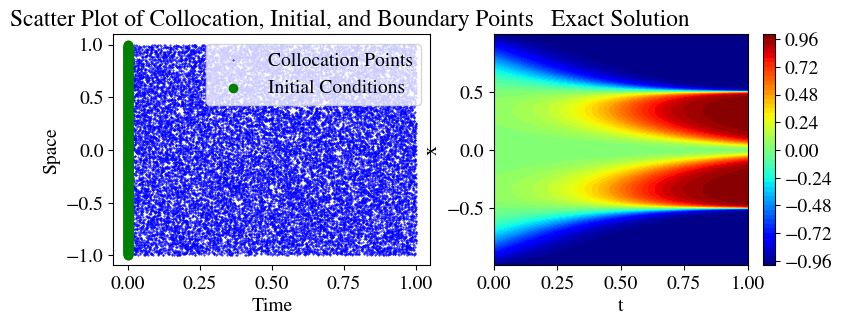

In [12]:
# Plotting code
fig = plt.figure(figsize=(9, 3))

# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()

# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.show()

In [13]:
# Batches SNR
n_batches=100
X_c2= lb_D + (ub_D-lb_D)*lhs(2, 2*NC)
X_batches=np.array(np.split(X_c2,n_batches))
X_batches.shape


(100, 512, 2)

## Initialize Model

In [14]:

# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,degree_T,feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optimizers = {
    'RBF_KAN_layer_0': optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False)),
    'get_Psi': optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False)),
}

# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(64, 64, 64, 64, 64)
118491


In [15]:
all_errors = []
all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []
all_lamE = []
all_lambdas=[]
start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/((EPOCHS)/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,alpha, *train_data)
    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 100 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        if max_RBA>cap_RBA+1:
            max_RBA=cap_RBA+1
            alpha=1
        gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        #Compute errors
        error = relative_l2(apply_fn(params, t, x), u_gt)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|")
        # Append metrics to lists
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)
        all_lamE.append(lamE)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

Training Progress:   0%|          | 0/300000 [00:00<?, ?it/s]

It: 300000/300000 | Error: 2.512e-05 | lam_max: 20.680| max_RBA: 21.000| lamB: 301.554|: 100%|██████████| 300000/300000 [1:33:04<00:00, 53.72it/s]

Runtime: 18.61 ms/iter.


# Save Results

In [16]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


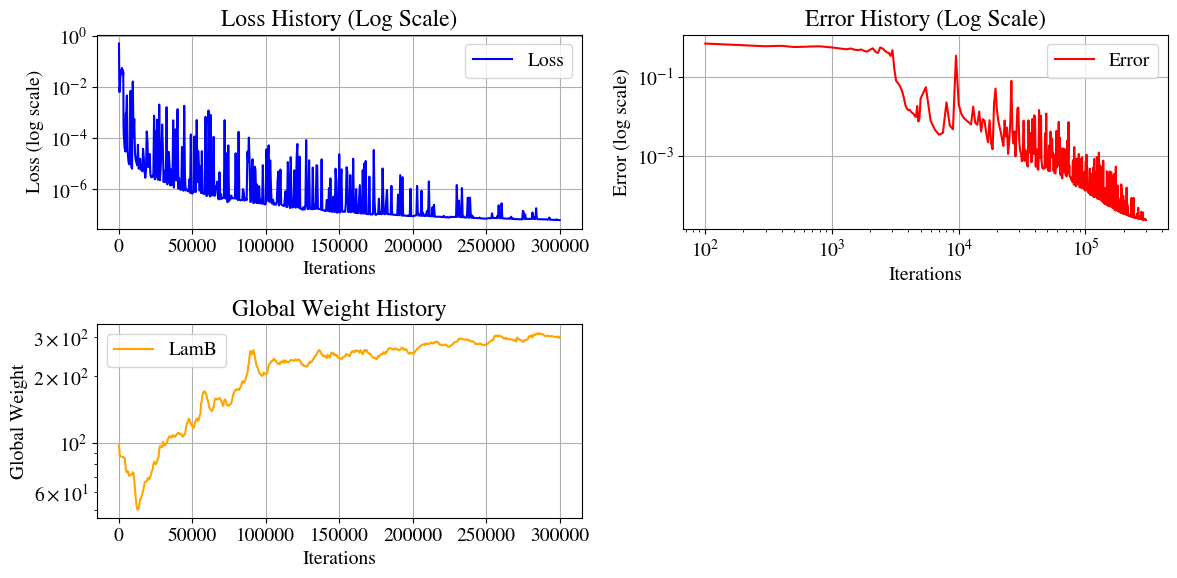

In [17]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_loss, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_errors, label='Error', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_lamB, label='LamB', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Global Weight')
plt.title('Global Weight History')
plt.grid(True)
plt.legend()



# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [18]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00002512


# Visualization

Solution:


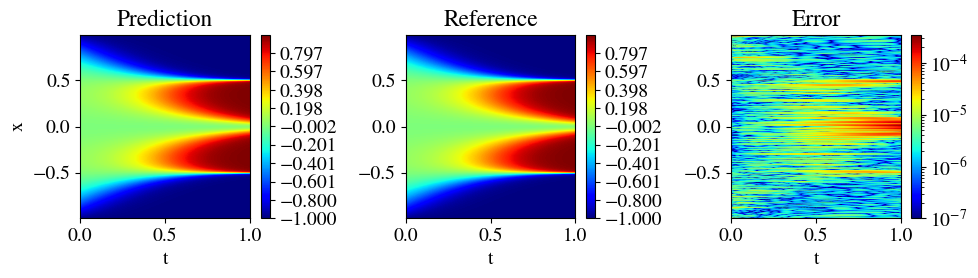

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

it=-1
print('Solution:')
# Assuming T, X, u, Exact0, args, etc. are already defined
# u = apply_fn(params, t, x)
# u = u.reshape(T.shape)
# lambdas_grid=all_lambdas[it]
# idx_it=all_idx[it]

# --- 1. Find the global vmin and vmax across BOTH datasets ---
global_vmin = np.min([u, Exact0])
global_vmax = np.max([u, Exact0])

# --- 2. Create a shared array of contour levels ---
# This is the key change that guarantees the colorbars are identical.
num_levels = 500
shared_levels = np.linspace(global_vmin, global_vmax, num_levels)


# Plotting code
fig = plt.figure(figsize=(10, 3))

# --- Plot for Prediction (using the shared levels array) ---
ax1 = fig.add_subplot(131)
contour1 = ax1.contourf(T, X, u, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# --- Plot for Reference Solution (using the shared levels array) ---
ax2 = fig.add_subplot(132)
contour2 = ax2.contourf(T, X, Exact0, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour2, ax=ax2)
ax2.set_xlabel('t')
#ax2.set_ylabel('x')
ax2.set_title('Reference')

# --- Plot for Error (this part is separate and correct) ---
ax3 = fig.add_subplot(133)
error_data = np.abs(Exact0-u)
log_norm = colors.LogNorm(vmin=1e-7, vmax=error_data.max())

mesh3 = ax3.pcolormesh(T, X, error_data, 
                       cmap='jet', 
                       norm=log_norm,
                       shading='gouraud')

fig.colorbar(mesh3, ax=ax3)
ax3.set_xlabel('t')
#ax3.set_ylabel('x')
ax3.set_title('Error')

plt.tight_layout()
plt.savefig('Errors_RBA_AC.png',dpi=300)
plt.show()

Solution:


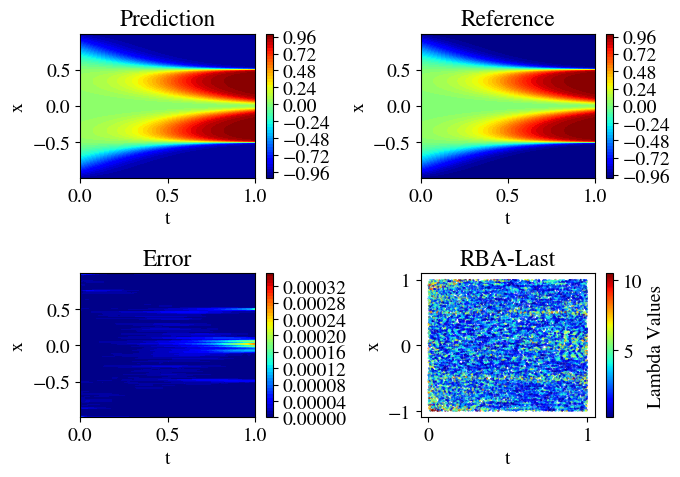

In [25]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
# Plotting code
fig = plt.figure(figsize=(7, 5))
levels=50
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(221)
contour = ax1.contourf(T, X, u, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(222)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(223)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
ax4 = fig.add_subplot(224)
scatter = ax4.scatter(tc, xc, c=lambdas_grid, cmap='jet', s=0.1,vmax=max_RBA/2)
cbar = fig.colorbar(scatter, ax=ax4)
cbar.set_label('Lambda Values')
ax4.set_xlabel('t')
ax4.set_ylabel('x')
ax4.set_title('RBA-Last')

plt.tight_layout()
plt.savefig(args.Name+'_Results.png')
plt.show()